# QAOA を利用して、組合せ最適化問題を解く

このチュートリアルでは、
- 組合せ最適化問題を紹介し、
- 近似最適化アルゴリズムの説明、
- 量子近似最適化アルゴリズム（Quantum Approximate Optimization Algorithm、QAOA）の動作説明、
- 及びシミュレーターもしくは実際の量子システムで動作する実装例

の紹介をします。

## 組合せ最適化問題

組合せ最適化問題には、有限のオブジェクトセットから最適なオブジェクトを見つけることが含まれます。有限のビット列の中から0と1で構成される「最適な」ビット列を見つけることを含む問題に焦点を当てます。グラフに対応するそのような問題の1つは、Max-Cut問題です。

### Max-Cut 問題

Max-Cut問題とは、グラフの頂点を2つのセットに分割し、その集合間の枝の数が最大となるようにする問題です。以下の例では、4つの頂点を持つグラフで、「赤」と「青」の2つの集合に分割する方法をいくつか示しています。

![](images/qaoa_maxcut.svg)

4個の頂点に対して、各頂点は「赤」と「青」のどちらかの集合に割り当てられるので、割り当ての可能性は $2^4=16$ 個あり、その中から「赤」と「青」の集合間の枝の数が最大となるものを探さなければなりません。図中の2つの集合の間の枝の数は、左から順に、0、2、2、4です。考えられる $2^4=16$ 個の割り当てをすべて列挙した結果、一番右の図が、2つの集合の間の枝の数が最大になる割り当てであることがわかります。したがって、「赤」を0、「青」を1としてエンコードすると、どちらかの集合に頂点を割り当てることを表すビット列「0101」「1010」が解となります。 

お気づきのように、グラフの頂点数が増えれば増えるほど、解を求めるために調べなければならない割り当ての可能性が指数関数的に増えていくのです。

## QAOA

Farhi et al.[1]が発表したQAOA（Quantum Approximate Optimization Algorithm、量子近似最適化アルゴリズム）は、このような組合せ問題を解決しようとする量子アルゴリズムです。<br>

これはパラメーター $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ で特徴付けられるユニタリー $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ を用いて量子状態 $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ を準備する変分アルゴリズムです。アルゴリズムの目的は、量子状態 $ \lvert \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle$ が問題の解をエンコードするような最適なパラメーター $ (\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}})$ を見つけることです。

ユニタリー $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ は特定の形式を持ち、2つのユニタリー $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ および $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$ で構成されています。ここで、$H_B$ はミキシングハミルトニアン、$H_P$ は問題のハミルトニアンです。このようなユニタリーの選択は、量子アニーリングと呼ばれる関連スキームからインスピレーションを得ています。

これらのユニタリーを、2つのユニタリーを交互に $p$  回適用したブロックとして、以下のように適用し、状態を準備します。

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p ; \text{times}} \lvert \psi_0 \rangle$$

ここで、$\lvert \psi_0 \rangle$ は適当な初期状態です。

これらのステップを、上述したMax-Cut問題を用いて説明します。そのために、我々はまず、上に示した問題の基礎となるグラフを定義することになります。

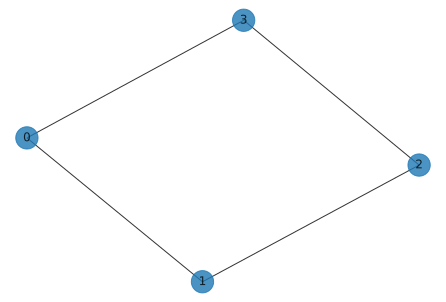

In [2]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

ここで、定数を除いて、Max-Cut問題に特有の問題ハミルトニアンは次の通りです。

$$ H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) + \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) + \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big) $$

このようなハミルトニアンを問題に対して構築するためには、このページの後のセクションで説明するいくつかのステップを踏む必要があります。

ミキサーハミルトニアン $H_B$ は通常、次のような形式です。

$$ H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) + \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) + \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) + \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big) $$

$H_P$ と $H_B$ の和の個々の項がともに交換するので、ユニタリーを次のように書くことができます。

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

上の積の各項は、各量子ビットのX回転に対応することに注意してください。そして、$U(H_P)$ を次のように書くことができます。

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

では、2つのユニタリーの回路がどのようなものかを見てみましょう。 

### ミキシングユニタリー

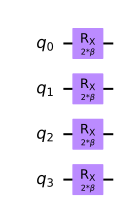

In [3]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw()

### 問題ユニタリー

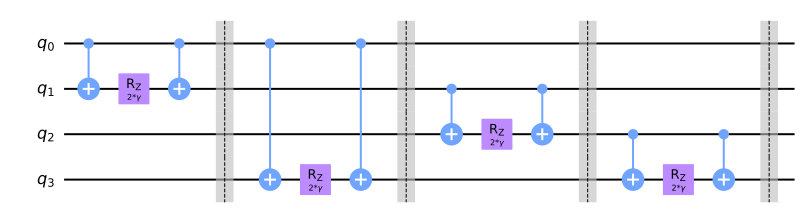

In [4]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw()

### 初期状態

QAOAで使用される初期状態は、通常、すべての基底状態の等しい重ね合わせです。つまり、

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

このような状態は、量子ビットの数が4 ($n=4$)のとき、以下の回路に示すように、すべてゼロの状態からアダマールゲートを適用して準備することができます。 

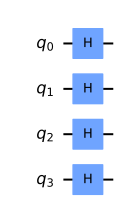

In [5]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

### QAOAの回路

これまで、QAOA時の量子状態の準備は、次の3つの要素で構成されていることを見てきました。

- 初期状態の準備
- 問題ハミルトニアンに対応するユニタリー $ U(H_P) = e^{-i \gamma H_P}$ の適用
- そして、ミキシングユニタリー $ U(H_B) = e^{-i \beta H_B}$ の適用

例題に対して、どのように見えるか見てみましょう。

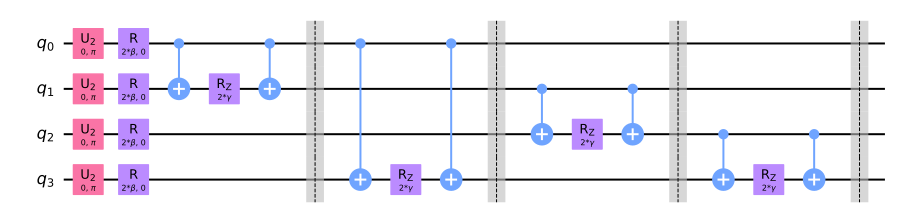

In [6]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

次のステップでは、期待値

$$ \langle \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rvert H_P \lvert 
\psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle $$

が最小になるような最適なパラメーター  $ (\boldsymbol{\beta_{\text{opt}}}, \boldsymbol{\gamma_{\text{opt}}})$ を探します。このような期待値は、Z基底で測定を行うことで得ることができます。最適なパラメーターを見つけるために、古典的な最適化アルゴリズムを使用します。模式図に示すように、以下のステップが含まれます。

<img src="images/QAOA_schematic.png" width="400" height="200" class="center">

1. $\boldsymbol{\beta}$ と $\boldsymbol{\gamma}$ を適当な実数値に初期化する。
2. 何らかの適切な収束基準が満たされるまで繰り返す。
    1. QAOA回路を使って状態 $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ を準備する。
    2. 状態を標準基底で測定する。
    3. $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $ を計算する。
    4. 新しいパラメーターセット $ (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$ を古典的な最適化アルゴリズムで求める。
    5. 現在のパラメーター $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ を新しいパラメーター $ (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$ に等しくする。

以下のコードは、上記のステップを実装したものです。

In [7]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    # pylint: disable=invalid-name
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(graph, shots=512):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [8]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

Qiskitには古典的なオプティマイザーの異なる選択肢が存在することに注意してください。ここでは古典的な最適化アルゴリズムとして[COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py)を選びます。

### 結果の分析

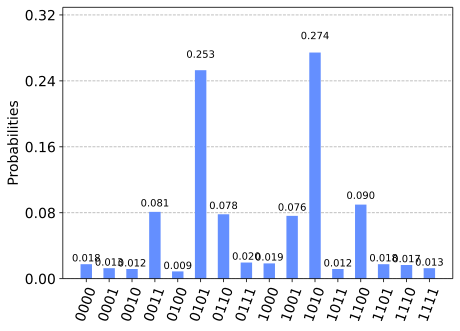

In [9]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

ビット列「0101」と「1010」は最も確率が高く、2つの分割の間に4本の枝を与える（最初にそこから始めた）グラフの割り当てであることに気づきます。 

## 付録

### 1. 問題ハミルトニアンの構築 <a id="Constructing Hamiltonian"></a>

どのような最大化問題も、最小化問題に変換できる（その逆も真）ので、組合せ最適化問題は一般的に次の形式で与えることができます。


$$ \text{maximize } \;\;      C(x)$$


$$ \text{subject to } \;\; x \in S $$


ここで、$x \in S$ は離散変数で、$C : D \rightarrow \mathbb{R}$ はコスト関数です。これは、ある定義域 $S$ からの実数 $\mathbb{R}$ への写像です。変数 $x$ は複数の制約を受け、実行可能解は $S \subset D$ 集合内に存在します。

0-1変数のみの組合せ最適化問題では、典型的なコスト関数は、$n$ビットのバイナリ文字列 $x \in {0,1}^n$ の部分集合 $Q \subset[n]$ を含む項の和で表されます。そのようなコスト関数 $C$ は、以下の形式で記述されます。

$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} ; \prod_{i\in Q} x_i ; \prod_{j\in \overline{Q}} (1- x_j), $$

ここで、$x_i \in {0,1}$、及び $w_{(Q,\overline{Q})}\in \mathbb{R}$ です。我々の目的は、$C(x)$ が最大になる、$n$ビット文字列 $x$ を探すことです。

#### 1.1 対角ハミルトニアン

コスト関数は、計算基底において対角なハミルトニアンにマッピングすることが出来ます。コスト関数 $C$ が与えられると、ハミルトニアンは次のように記述できます:

$$ H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x| $$

ここで$x \in {0,1}^n$ は、計算基底 $|x \rangle \in \mathbb{C}^{2^n}$ でのラベルです。仮にコスト関数が高々$k$個の重み付き項しかない場合、つまり $Q$ が高々 $Q \leq k$ ビットしか含まない時には、この対角ハミルトニアンは、$k$ 個の重み付きパウリ $Z$ 演算子の和になります。

$H$ のパウリ $Z$ 演算子への展開は、コスト関数 $C$ の正規展開において、全てのバイナリ変数 $x_i \in {0,1}$ を行列 $ x_i \rightarrow 2^{-1}(1 - Z_i)$ に置き換えることで得られます。ここで、$Z_i$ は量子ビット $i$ に作用し、その他には自明なパウリ $Z$ 演算子、すなわち次の通りです。

$$ Z_i = \left(\begin{array}{cc} 1 & 0 \\ 0 & -1 \end{array}\right). $$

これは、古典コスト関数をエンコードするスピン-ハミルトニアンが $|Q|$ と記述され、ローカル量子スピンハミルトニアンがパウリ $Z$ 演算子しか含まないことになります。

$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} ; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) ; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$

ここで、数少ない($n$ の多項式) $w_{(Q,\overline{Q})}$ のみが非ゼロであると想定します。また、集合 $|(Q,\overline{Q})|$ は有界であり、大きくないと想定します。これは、コスト関数とハミルトニアン $H$ が $m$ 個のローカル項 $\hat{C}_k$ の和として書けることを意味します。

$$ H = \sum_{k = 1}^m \hat{C}_k, $$

ここで、$m$ と $\hat{C}_k$ の台は妥当性のある有界値です。

### 2 様々な例 <a id="examples"></a>

ここでは組合せ最適化問題を2つ例示します。最初の例のみQiskitで実装しますが、演習問題を通じて2番目の例の実装方法を示します。

#### 2.1 (重みつき) MAXCUT

$n$ 個の頂点の無向グラフ *G = (V, E)* (*|V| = n*) で、枝の重みが $w_{ij}>0$ で $(i,j)\in E$ に対して $ w_{ij}=w_{ji}$ であるものを考えます。カットとは、元の集合Vを2つの部分集合に分割することです。最適化されるコスト関数は、この場合、2つの異なる部分集合の点を結び、カットを*横切る*枝の重みの合計です。各頂点 $i$ に $x_i=0$ または $x_i=1$ を割り当てることにより、大域的利益関数を最大化しようとします（以下、和は1,2,...,nのインデックスをとります）。

$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$

表記を簡単にするために、以下では $(i,j) \in E$ に対して均一の重み $ w_{ij} = 1$ を仮定します。量子コンピューター上でこの問題の最適解を見つけるためには、上記で説明したように、まずこれを対角ハミルトニアンにマッピングする必要があります。集合 $E$ の枝の総和を以下のように記述します。

$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$

これをスピンハミルトニアンにマップするために $ x_i\rightarrow (1-Z_i)/2$ の変換を行います。ここで、$Z_i$ は固有値 $\pm 1$ をもつパウリZ演算子で、$C(\textbf{x}) \rightarrow H$ を得ます。

$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$

この式が意味することは、ハミルトニアンは次の $m = |E|$ 個のローカル項の和として記述できるということです。

$$\hat{C}_e = \frac{1}{2}\left(1 - Z_{e1}Z_{e2}\right)$$

ここで $e = (e1,e2) \in E$ です。

#### 2.2 制約充足問題と $\text{MAX 3-SAT}$

組合せ最適化問題の別の例として、 $\text{3-SAT}$ があります。ここで、コスト関数 $ C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})$ は、節に参加するいくつかの $\textbf{x} \in {0,1}^n$ のうちの $3$ ビット分の値を制約する節 $c_k(\textbf{x})$ の総和です。例えば、ビット列 $\textbf{x} \in \{0,1\}^{133}$ に対する次のような $\text{3-SAT}$ 節を考えます。

$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$

この節は $x_1 = 0$ 、 $x_3 = 0$ および $x_{132} = 1$ の時のみ充足します。 $\text{3-SAT}$ 問題は、$m$ 個の節をすべて充足するビット列が存在するか、存在しないかを問うものです。この決定問題は、 $NP$ 完全な問題の主要な例です。

密接に関連する最適化問題 $\text{MAX 3-SAT}$ は、 $C(\textbf{x})$ に含まれる節のうち、充足する節の数を最大化するビット列 $\textbf{x}$ を求めるものです。もちろん、$m$ 個の節のうち $\tilde{m}$ 個以上を満たすビット列がどこに存在するかを問えば、再び決定問題となり、これも $NP$ 完全となります。

### 3. 近似アルゴリズム<a id="approximateOPT"></a>

これまでに紹介した $MAXCUT$  と$\text{MAX 3-SAT}$ の両者はNP困難として知られています [3](#references)。実は、一般的に組合せ最適化問題の多くは、解を求めることが計算上困難です。この事実に照らし合わせてみると、効率的なアルゴリズム、つまり問題のサイズに対して多項式時間でこれらの問題を解くアルゴリズムを見つけることは期待できません。これは量子アルゴリズムにも当てはまります。このような問題を扱うには、主に2つのアプローチがあります。1つ目のアプローチは、多項式時間内に指定された品質の解を見つけることが保証されている近似アルゴリズムです。2つ目のアプローチは、多項式の実行時間は保証されていないものの、一部の問題例で良好なパフォーマンスを発揮するヒューリスティックなアルゴリズムです。

近似最適化アルゴリズムは効率的であり、近似解が問題の実際の最適解にどの程度近いかの理論保証を与えます。保証は典型的には、近似比 $\alpha \leq 1$ で示されます。確率的近似最適化アルゴリズムの場合、*高い確率で*正の $ C_\text{max} = \max_{\textbf{x}}C(\textbf{x})$ を持つビット列 $\textbf{x}^* \in {0,1}^n$ を生成することを保証します。

$$ C_\text{max} \geq C(\textbf{x}^*) \geq \alpha C_\text{max}. $$

$MAXCUT$ 問題に関しては、Goemans および Williamson [2](#references) による有名な近似アルゴリズムがあります。このアルゴリズムは元の問題のSDP緩和と確率的丸めのテクニックを組み合わせて、$\alpha \approx 0.878$ という近似比の近似解を高い確率で出力します。この近似比は量子アルゴリズムをもってしても改善することができない最適な値と考えられています。

### 4. QAOA <a id="QAOA"></a>

Farhi、Goldsone、Gutmann [1](#references) による量子近似最適化アルゴリズム (Quantum approximate optimization algorithm, QAOA) は、ヒューリスティック・アルゴリズムの一例です。Goemans-Williamsonアルゴリズムとは異なり、QAOAでは性能が保証されていません。QAOAは古典的な近似アルゴリズムの考え方を取り入れ、高確率で良い近似比 $\alpha$ が期待できる古典的なビット列 $x^*$ を同様に生成する量子的類似物を探します。詳細を議論する前に、まずこのアプローチの一般的な考え方を紹介しましょう。

#### 4.1 概要

我々は、問題のハミルトニアン $H$ に対して期待値が最大になるような、実数パラメーター $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$ を持つ量子状態 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ を見つけたいと考えています。この試行状態が与えられたとき、$ F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ を最大化するパラメーター $\vec{\gamma}^*,\vec{\beta}^*$ を探します。

このような状態と対応するパラメータが得られたら、量子コンピューター上で状態 $|\psi_p(\vec{\gamma}^*,\vec{\beta}^*)\rangle$ を準備し、$Z$ 基底 $ |x \rangle = |x_1,\ldots x_n \rangle$ で状態を測定してランダムな出力 $x^*$ を得ます。

このランダムなビット列 $x^*$ は、期待値 $ M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$ に高確率で近くなります。したがって、もし $M_p$ が $C_\text{max}$ に近いならば、$C(x^*)$ も同様です。

#### 4.2 QAOA の構成要素

#### 4.2.1 QAOA の試行状態 <a id="section_421"></a>

QAOAの中心となるのは、量子コンピュータ上に用意される試行状態 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ です。理想的には、この状態が問題のハミルトニアン $H$ に対して、大きな期待値 $ F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ をもたらすことが望まれます。Farhi [1](#references) では、試行状態 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ は一量子ビットのパウリ $X$ 回転と問題のハミルトニアン $H$ から構築されます。つまり、計算基底で対角な問題のハミルトニアン

$$ H = \sum_{k = 1}^m \hat{C}_k $$

と、横磁場のハミルトニアン

$$ B = \sum_{i = 1}^n X_i $$

が与えられたとき、試行状態は、$ X |+\rangle = |+\rangle$ となる $|+\rangle$ の積状態 $|+\rangle^n$ に以下のように交互に $p$ 回 $B$ と $H$ に関するユニタリー行列をかけることで用意します。

$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$

のように交互に $p$ 回 $B$ と $H$ に関するユニタリー行列をかけることで用意します。

この特定のansatzの利点は、$ M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$ としたときに極限 が $ \lim_{p \rightarrow \infty} M_p = C_\text{max}$ となるようなベクトル $\vec{\gamma}^*,\vec{\beta}^*$ が明確に存在することです。これは、試行状態 $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ を、$H$ と横磁場ハミルトニアン $B$ に関して断熱発展をトロッター展開をして得られる状態とみなせます（参考文献 [1](#references)）。

この試行状態の欠点は、一般的にあまり深くない量子回路から生成された状態が生成されることです。ここで、深さは量子チップ上に直接作用するゲートの数で決まります。したがって、量子チップのハードウェアにより合わせた試行状態の提案があります (参考文献 [4](#references)、 [5](#references)) 。

#### 4.2.2 期待値の計算 <a id="section_422"></a>

このアプローチの重要な構成要素は、以下の期待値を計算もしくは推定することです。

$$ F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle $$

これにより、パラメーター $\vec{\gamma},\vec{\beta}$ の最適化をします。

#### 古典的な期待値の評価方法

なお、$|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ の試行状態の回路があまり深くない場合、期待値 $F_p$ を古典的に評価できる場合があります。

例えば、次数が制限されたグラフに対する MAXCUT で、$p=1$ の回路を考える場合です。セクション 5.2にてQiskitでの実装例を見て、期待値を計算する演習問題を提供します。

このアイデアを説明するにはハミルトニアンが、$ H = \sum_{k = 1}^m \hat{C}_k$ のように個々の項の和として記述されることを思い出してください。期待値の線形性により、個々の被加数の期待値を考えれば十分です。$p = 1$ の場合は、以下の通りです。

$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle =  \langle +^n | e^{ i\gamma_1 H } e^{   i\beta_1 B } | \hat{C}_k |  e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle $$

$B = \sum_{i = 1}^n X_i$ において、ユニタリー行列 $e^{ -i\beta_1 B }$ は、実際のところ角度 $\beta$ での単一量子ビットの回転 $X$ の積であることに注意してください。これを、$ X(\beta)_k = \exp(i\beta X_k)$ と記述します。

$\hat{C}_k$ の台である量子ビットに作用しない全ての個々の回転は、$\hat{C}_k$ と可換で、すなわちキャンセルされます。これは演算子 $\hat{C}_k$ の台を増やしません。これは、ユニタリー・ゲート $ e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)$ の第2集合が、演算子 $ e^{ i\beta_1 B } \hat{C}_k  e^{ -i\beta_1 B }$ と可換な、ゲート $ U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ の大きな集合であること意味します。期待値に寄与するゲート $U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ だけが、元の $\hat{C}_k$ の台である量子ビットを含むゲートになります。

これ故、制限された次数での相互作用において、$ e^{ i\gamma_1 H } e^{   i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }$ の台は、$H$ の相互作用の次数により与えられる量によってのみ拡張します。すなわちシステムのサイズとは独立です。つまり、これらのより小さい部分問題において、期待値は $n$ と独立で、古典的に推定できることを意味します。一般的な次数 $3$ のケースは、参考文献 [1](#references) にて考察されています。

これは一般的な見解であり、試行状態の準備に使われている回路がハミルトニアンのそれぞれの項の台を定数しか増やさない場合、コスト関数は直接推定できることを意味します。

この様な場合、かつ試行状態の準備に数個のパラメーター $\beta, \gamma$ だけが必要な場合は、単純なグリッド探索で簡単に見つけることができます。さらに、$M_p$ の厳密な最適値を用いて、近似比の上限

$$ \frac{M_p}{C_\text{max}} \geq \alpha $$

から $\alpha$ の推定値を取得できます。この場合、QAOAは問題サイズの多項式時間で保証つきの近似比が得られる従来の近似最適化アルゴリズムと同じ特徴を持ちます。

#### 量子コンピューター上での評価方法

量子回路が深すぎて古典的に評価できない時、もしくは問題ハミルトニアンの結合が高すぎる時は、期待値を推定する別な手段を利用します。量子コンピューター上 で$F_p(\vec{\gamma},\vec{\beta})$ を直接推定する方法を含みます。ここでは、VQE [4](#references) で用いられていた、量子コンピューター上に直接試行状態 $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle$ を用意し、サンプリングから期待値を求める、従来の期待値推定の手法を踏襲しています。

QAOAは対角ハミルトニアン $H$ を持つので、期待値を推定するのは実に簡単です。計算基底の試行状態からサンプルを入手するだけでよいのです。$H = \sum_{x \in {0,1}^n} C(x) |x \rangle\langle x|$ であることを思い出すと、

$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in {0,1}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$

のサンプリング推定値を、$Z$ 基底での状態 $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle $ の単一量子ビット測定を繰り返すことで、取得することができます。分布 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ から得られた各ビット文字列 $x$ について、コスト関数 $C(x)$ を評価し、サンプルの総数で平均化します。結果として得られる経験的平均は、状態の分散内にある加法性サンプリング誤差まで期待値を近似します。分散については後述します。

期待値を計算できると、参考文献 [6](#references) のような古典的な最適化アルゴリズムを実行することで、$F_p$を最適化できます。

このアプローチは、$x^*$の理論的近似保証を与えませんが、最適化された関数値から近似比率 $\alpha$ を推定することができます。

#### 4.3.3 高確率で所定の近似比率の解を得ること

このアルゴリズムは、本質的に確率的であり、確率分布 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ からランダムなビット列を生成します。では、最適化された期待値 $M_p$ の値に近い近似値 $x^*$ をサンプリングすることをどのように確認できるのでしょうか？この質問は、そもそも量子コンピューター上での $M_p$ の推定にも関連していることに注意してください。もし $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ から引き出したサンプルの分散が大きすぎる時、平均を決定するためには多くのサンプルが必要です。

変数であるエネルギーの分散が少ないときに、平均 $M_p$ に近いビット文字列 $x^*$ を高確率で引き出します。

ハミルトニアン $ H = \sum_{k=1}^m \hat{C}_k$ の項数は $m$ 以下になることに注意してください。つまり個々の被加数 $\hat{C}_k$ は、全て の$k = 1\ldots m$ に対し $|\hat{C}_k| \leq \tilde{C}$ の形で共通の定数で制限される演算子ノルムを持つと仮定します。次に、以下を考えます。

$$
\begin{aligned}
\langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &\leq  \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \\
&= \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \\
&\leq m^2 \tilde{C}^2 \\
\end{aligned}
$$


ここで $ \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2$ を使用しました。

これは、どんな期待値 $F_p(\vec{\gamma},\vec{\beta})$ の分散も $m^2 \tilde{C}^2$ 以下になることを意味します。これは $M_p$ にも当てはまります。さらに $m$ が量子ビット数 $n$ の多項式的にしか増えない場合、 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ から、多項式的に増える数 $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon^2}\right)$ のサンプルを引き出せば、$M_p$ に近い $C(x^*)$ を導く $x^*$ を得るのに十分です。

### 5. 問題<a id="problems"></a>

0. QAOAはビット文字列を生成しますが、この文字列はそのグラフにとって最適解でしょうか？実機上の実験結果とローカルQASMシミュレーターの結果を比較してください。

1. [セクション 5.2](#implementation_sec52) で、コスト関数 $F_1$ を解析的に計算しました。ステップを検証し、$f_A(\gamma,\beta)$ ならびに $f_B(\gamma,\beta)$ を計算してください。

2. Qiskitでの実装において $F_1$ の正確な式が与えられました。

    - 結果で得られたサンプルから期待値 $F_1(\gamma,\beta)$  を推定するルーチンを作成してください (ヒント: [セクション 5.4](#implementation_sec54)でのcost_function_C(x,G)関数とセクション[5.a / 5.b](#implementationsim)のデータの評価を使用します)。

    - 最適化ルーチン、例えばこのチュートリアルのVQEの例のSPSAなどを使って、サンプリングされた $F_1(\gamma,\beta)$ のパラメーターを数値的に最適化してください。$\gamma^*,\beta^*$ に対し同じ値を見つけましたか？

3. 結果で得られたサンプルから期待値 $F_1(\gamma,\beta)$ を推定するルーチンを作成してください (ヒント: [セクション 5.4](#implementation_sec54) での cost_function_C(x,G)関数 と [セクション 5.a / 5.b](#implementationsim)のデータの評価を使用します)。

    - 問題2のルーチンを使って、$p=2,3$ に対しコスト関数 $F_p(\gamma,\beta)$ を評価してください。実機上での実行でどうなると思いますか？
    - 参考文献 [4](#references) のハードウェアに特化した試行状態を参考にして、この節で取り上げた試行状態のクラスを他の波動関数の候補に一般化してください。


## 参考文献[](#references)

1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table